<!---
layout: post
title: Influence Maximization in Python - Greedy vs CELF
tags: 
- Python
- igraph
- Network Analysis
- Influence Maximization
--->

<center> <h1>Influence Maximization in Python - Greedy vs. CELF</h1> </center>

Influence Maximization (IM) is a field of network analysis with a lot of applications - from viral marketing to disease modelling and public health interventions. IM is the task of finding a small subset of nodes in a network such that the resulting "influence" propagating from that subset reaches the largest number of nodes in the network. "Influence" represents anything that can be passed across connected peers within a network, such as information, behavior, disease or product adoption.

[Kempe et al. (2003)](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf) were the first to formalize IM as the following combinatorial optimization problem: Given a network with $n$ nodes and given a "spreading" or propagation process on that network, choose a "seed set" $S$ of size $k<n$ to maximize the number of nodes in the network that are ultimately influenced.

Solving this problem turns out to be extremely computationally burdensome. For example, in a relatively small network of 1,000 nodes, there are ${n\choose k} \approx 8$ trillion different possible candidates of size $k=5$ seed sets, which is impossible to solve directly even on state-of-the-art high performance computing resources. Consequently, a very active literature over the last 15 years has tried to find approximate solutions to the problem that can be solved quickly. This post walks through how to implement two of the earliest and most fundamental approximation algorithms in Python - the Greedy and the CELF algorithms - and compares their performance.

We begin by loading some packages. There are many popular network modelling packages, but we'll use [`igraph`](http://igraph.org/python/) (in the [next post](https://hautahi.com/im_ris), I use a simple [`pandas`](https://pandas.pydata.org/) dataframe approach instead and in a [later post](https://hautahi.com/ic_comparison), I compare a range of approaches and packages).

In [2]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
from igraph import *

## Spread Process - Independent Cascade

IM algorithms solve the optimization problem for a given spread or propagation process. We therefore first need to specify a function that simulates the spread from a given seed set across the network. We'll simulate the influence spread using the popular "Independent Cascade" model, although there are many others we could have chosen. The `IC()` function describing the spread process is presented below.

In [3]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

We calculate the expected spread of a given seed set by taking the average over a large number (`mc`) of Monte Carlo simulations. The outer loop in the `IC()` function iterates over each of these simulations and stores each calculated spread in the `spread` list. The mean of each of these entries, which is a consistent and unbiased estimator for the expected spread of the seed set `S`, is then returned as the function output.

Within each Monte Carlo iteration, we simulate the spread of influence throughout the network over time, where a different "time period" occurs within each of the `while` loop iterations, which simply checks whether any new nodes were activated in the previous time step. If no new nodes were activated (when `new_active` is an empty list and therefore evaluates to `False`) then the independent cascade process terminates, and the function moves onto the next simulation after storing the total spread, which is simply the number of nodes ultimately activated (some algorithms are framed in terms of the "additional spread" in which case we would subtract the size of the seed set so that the function would be ammended to `spread.append(len(A)-len(S))`. 

The third loop performs the actual propagation process on the graph object `g`. For each `node` that was newly activated in the previous time step, we construct a vector array `success` where each entry indicates whether each of `node`'s out-neighbors is activated by comparing a uniform random draw with the propagation probability `p`. (The `np.random.seed(i)` function is used to ensure consistency of results when comparing the processes below.) Those nodes that are successfully activated (`new_ones`) are then selected and if some are not already included within the active set `A` they are added.

## Greedy Algorithm

With our spread function `IC()` in hand, we can now turn to the IM algorithms themselves. We begin with the **Greedy** algorithm proposed in the seminal [Kempe et al. (2003)](https://www.cs.cornell.edu/home/kleinber/kdd03-inf.pdf) paper. This basically finds the node with the biggest spread, adds it to the seed set and then finds the node with the next biggest marginal spread over and above the spread of the original and so on until $k$ seed nodes are found.

This algorithm only needs to calculate the spread of $\sum_{i=0}^k (n-i)\approx kn$ nodes, which is just 5,000 in the case of our 1,000 node and $k=5$ network (a lot less that 8 trillion!). Of course, this computational improvement comes at the cost of the resulting seed set only being an approximate solution to the IM problem because it only considers the incremental spread of the $k$ nodes individually rather than combined. Fortunately, however, the authors show that the algorithm is theoretically guaranteed to choose a seed set whose spread will be at least 63% of the spread of the optimal seed set. No better theoretically proved approximation has been found (and in fact, most of the algorithms proposed in the literature don't have any theoretical guarantees). The proof of the guarantee is in the paper, but it relies heavily on the "submodular" property of spread functions, which is a kind of set function analogue of concavity, and will be explained in more detail below when we look at the CELF algorithm.

The following `greedy()` function implements the algorithm. It produces the optimal set of `k` seed nodes for the graph `g`, and is explained in more detail below.

In [4]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

The `greedy()` function performs the same operation for all $k$ iterations of the outer `for` loop. Specifically, it calculates the marginal spread for all remaining candidate nodes and then selects the node with the highest spread.

The calculation of the spread for all nodes takes place in the inner `for` loop that iterates over the nodes in `rangelist`, which is computed by subtracting the nodes in the current seed set from the full set of nodes `g.vcount()`. Within each iteration, the marginal spread is computed by calling the `IC()` function, where the input seed set is equal to the union of `S` and the current node `j`. The marginal spread for `j` is then compared to the largest spread in the loop so far (`best_spread`) and if it is greater, then that node becomes the current "leader".

The function not only returns the optimal seed set `S` but also the average spread of that seed set along with a list showing the cumulative time taken to complete each iteration (which we'll compare with CELF below).

## Cost Effective Lazy Forward (CELF) Algorithm

The **CELF** algorithm was developed by [Leskovec et al. (2007)](https://www.cs.cmu.edu/~jure/pubs/detect-kdd07.pdf). Although the Greedy algorithm is much quicker than solving the full problem, it is still very slow when used on realisticaly sized networks. CELF was one of the first significant subsequent improvements.

CELF exploits the sub-modularity property of the spread function, which implies that the marginal spread of a given node in one iteration of the Greedy algorithm cannot be any larger than its marginal spread in the previous iteration. This helps us to choose the nodes for which we evaluate the spread function in a more sophisticated manner, rather than simply evaluating the spread for all nodes. More specifically, in the first round, we calculate the spread for all nodes (like Greedy) and store them in a list, which is then sorted. Naturally, the top node is added to the seed set in the first iteration, and then removed from the list. In the next iteration, only the spread for the top node is calculated. If, after resorting, that node remains at the top of the list, then it must have the highest marginal gain of all nodes. Why? Because we know that if we calculated the marginal gain for all other nodes, they'd be lower than the value currently in the list (due to submodularity) and therefore the "top node" would remain on top. This process continues, finding the node that remains on top after calculating its marginal spread, and then adding it to the seed set. By avoiding calculating the spread for many nodes, CELF turns out to be much faster than Greedy, which we'll show below.

The `celf()` function below, which implements the algorithm, is split into two components. The first component, like the Greedy algorithm, iterates over each node in the graph and selects the node with the highest spread into the seed set. However, it also stores the spreads of each node in the sorted list `Q` for use in the second component.

The second component iterates to find the remaining `k-1` seed nodes. Within each iteration, the algorithm evaluates the marginal spread of the top node in the list `Q` and replaces it within the list. If, after resorting, the top node stays in place (`Q[0][0] == current`) then that node is selected as the next seed node. If not, then the marginal spread of the new top node within `Q` is evaluated and so on.

Like `greedy()`, the function returns the optimal seed set, the resulting spread and the time taken to compute each iteration. In addition, it also returns the list `LOOKUPS`, which keeps track of how many spread calculations were performed at each iteration. We didn't bother doing this for `greedy()` because we know the number of spread calculations in iteration $i$ is $N-i-1$.

In [5]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

## Example 1: A Simple Test Run

We'll first test these algorithms to see if they can produce the correct solution for a simple example for which we know the two most influential nodes. Below we create a 10-node/20-edge weighted and directed `igraph` network object. This artifically created network is designed to ensure that nodes `0` and `1` are the most influential. We do this bycreating 8 links outgoing from each of these nodes compared to a maximum of one from the other 8 nodes. We also make sure that `0` and `1` are not neighbors so that having one in the seed set does not make the other redundant. Plotting the network allows us to gain some visual intuition as to why nodes `0` and `1` are the most influential.

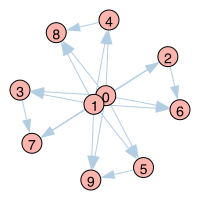

In [6]:
# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

g = Graph(directed=True)
g.add_vertices(range(10))
g.add_edges(zip(source,target))

# Plot graph
g.vs["label"], g.es["color"], g.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
plot(g,bbox = (200,200),margin = 20,layout = g.layout("kk"))

With this graph in hand we can now run each of the algorithms, which both manage to correctly identify nodes 0 and 1 as the influencers. This gives us some confidence that our code is working correctly.

In [7]:
# Run algorithms
celf_output   = celf(g,2,p = 0.2,mc = 1000)
greedy_output = greedy(g,2,p = 0.2,mc = 1000)

# Print results
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [0, 1]
greedy output: [0, 1]


## Example 2: Larger Network

Now that we know that both alorithms at least work correctly for a simple network for which we know the answer, we move to a more generic graph to compare the performance and efficiency of each method. Any `igraph` network object will work, but for the purposes of this post we will use a random Erdos-Renyi graph with 100 nodes and 300 edges. The exact type of graph doesn't matter as the main points hold for any graph. Rather than explicitly defining the nodes and edges like we did above, here we make use of the `.Erdos_Renyi()` method to automatically create the graph. Plotting the network shows that we're now dealing with a larger more complicated network where the identity of the most influential nodes is no longer obvious.

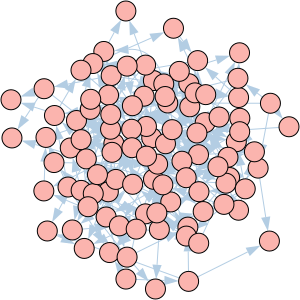

In [8]:
# Generate Graph
G = Graph.Erdos_Renyi(n=100,m=300,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))

We now run each of the algorithms to solve for a seed set of size $k=10$ and we opt for `mc=1000` Monte Carlo simulations. (10,000 simulations are commonly used in the literature, but we choose a lower number here so we don't have to wait as long for the results. You may want to try `mc=100`, as we're not interested in getting the best result but rather in comparing the two methods, so the choice of `mc` is arbitrary.) Both approaches yield identical seed sets.

In [9]:
# Run algorithms
celf_output   = celf(G,10,p = 0.1,mc = 1000)
greedy_output = greedy(G,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [81, 42, 37, 9, 0, 39, 66, 86, 67, 50]
greedy output: [81, 42, 37, 9, 0, 39, 66, 86, 67, 50]


We now compare the speed of each algorithm. The plot below shows that the computation time of Greedy is larger than CELF for all seed set sizes greater than 1 and the difference in computational times grows exponenitally with the size of the seed set. This is because Greedy must compute the spread of $N-i-1$ nodes in iteration $i$ whereas CELF generally performs far fewer spread computations after the first iteration.

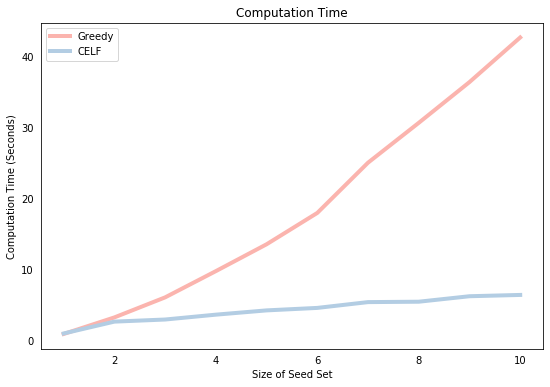

In [11]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output[2])+1),greedy_output[2],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

We can get some further insight into the superior computational efficiency of CELF by observing how many "node lookups" it had to perform during each of the 10 rounds. The list stored in `celf_output[3]` shows that the first round iterated over all 100 nodes of the network. This is identical to Greedy which is why the graph above shows that the running time is equivalent for $k=1$. However, for subsequent iterations, there are far fewer spread computations because the marginal spread of a node in a previous iteration is a good indicator for its marginal spread in a future iteration. Note the relationship between the values below and the corresponding computation time presented in the graph above. There is a visible jump in the blue line for higher values of the "node lookups".

In [14]:
print(celf_output[3])

[100, 100, 12, 22, 34, 8, 13, 24, 2, 18]


Finally, we plot the resulting expected spread for each seed set size. Of course, both methods yield the same expected spread, which is simply a function of the identical seed sets, but note that the function is concave, which is consistent with the submodularity of the spread function.

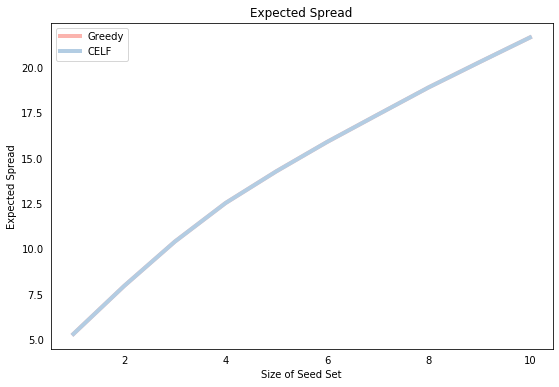

In [14]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output[1])+1),greedy_output[1],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);

## Conclusion

We implemented both the Greedy and CELF algorithms as simple Python functions and showed the following:

- Both correctly identify the influential nodes in simple examples
- Both result in the same seed set
- The CELF algorithm runs a lot faster for any seed set $k>1$.
- The speed arises from the fact that after the first round, CELF performs far fewer spread computations than Greedy.

The source code for this post is available at its [Github repository](https://github.com/hautahi/IM_GreedyCELF), where you'll also find instructions on how to install igraph plotting functionalities, which a lot of people including myself have run into trouble with.